# Unsupervised Learning Capstone Project - Twitter Text Clustering

Twitter captures what's happening in the world and what people are talking about. Around 500 million tweets are sent each day, meaning 6000 a second. In this project, I focus on the conversations being had about George Floyd, the 46-year-old black man who died in Minneapolis, Minnesota, after police officer Derek Chauvin knelt on his neck for almost nine minutes. I attempt to cluster these conversations to get a better understand of what people around the country and the globe are saying about this event.

## Imports

In [83]:
from collections import Counter
import itertools as it
import json
import logging
import os
import re
import string
import sys

import tweepy
import jsonpickle
from bokeh.plotting import figure, ColumnDataSource, show, output_notebook; output_notebook()
from bokeh.models import HoverTool
from bokeh.palettes import brewer, Viridis256
import matplotlib.pyplot as plt
from nltk.util import everygrams
from nltk.tokenize.casual import TweetTokenizer
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import TruncatedSVD
from stop_words import get_stop_words
from tweet_parser.tweet import Tweet
from searchtweets import load_credentials, gen_rule_payload, collect_results
from sklearn.cluster import AgglomerativeClustering
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
import umap
import nltk
import yaml

seed = 42

# better viewing of tweet text
pd.options.display.max_colwidth = 350

Loading BokehJS ...

In [1]:
nltk.download('stopwords')
set(stopwords.words('english'))

Loading BokehJS ...

C:\Users\sebar\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\sebar\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sebar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# API Credential Authentication

In [2]:
# Replace the API_KEY and API_SECRET with your application's key and secret.
auth = tweepy.AppAuthHandler('lJH7kNKa4dqYmYkokpaZHy8NB', 'G0BI6qiWFoMzwWCaCa30y5MmWfNFIhh2xI7hua10iAycSZ8aa1')

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)

# Continue with rest of code

## Twitter Scrape

Initially, we were getting a very large amount of duplicate tweets, such that a 30,000 row dataframe actually contained only 573 unique values. Thus, I filtered out retweets and added some code in the loop below to scrape tweets only once. However, because the API has a cap on how many tweets you can scrape per time interval, my dataframe size was now constrained by the amount of time it took to scrape it. Thus, I made the decision to reduce the target size of my dataframe to 10,000 tweets, which took a bit over three hours to compile.

In [329]:
searchQuery = 'George Floyd -filter:retweets'  # this is what we're searching for
max_tweets = 10000 # Total observation count desired for our dataframe
count = 100 # this is the maximum the API permits
log_every_n = 200 # For printing purposes in the loop
id_list = [] # We will use this list to validate tweet uniqueness
tweet_list = [] # Approved tweets will be appended here

tweet_count = len(tweet_list)
print("Downloading max {0} tweets".format(max_tweets))
while tweet_count < max_tweets:
    try:
    # Pulling individual tweets from query
        for i in api.search(q=searchQuery, count=count, lang='en', tweet_mode='extended', since='2020-06-01'):
            id_list.append(i.id)
            # Confirmed the tweet (denoted by user id) has not already by appended
            if id_list.count(i.id) < 2:
                # Adding to list that contains all tweets
                tweet_list.append((i.created_at, i.full_text, i.id, i.user.screen_name, i.user.description, i.user.location))
        tweet_count = len(tweet_list)
        if (tweet_count % log_every_n == 0):
            print("Downloaded {0} tweets".format(tweet_count))
    except BaseException as e:
        print('failed on_status,',str(e))
        time.sleep(3)

Downloaded 600 tweets
Downloaded 800 tweets


Rate limit reached. Sleeping for: 544


Downloaded 1000 tweets
Downloaded 1000 tweets
Downloaded 1200 tweets
Downloaded 1200 tweets
Downloaded 1400 tweets


Rate limit reached. Sleeping for: 588


Downloaded 2200 tweets


Rate limit reached. Sleeping for: 532


Downloaded 2800 tweets
Downloaded 3000 tweets
Downloaded 3000 tweets


Rate limit reached. Sleeping for: 500


Downloaded 3800 tweets
Downloaded 4200 tweets


Rate limit reached. Sleeping for: 483


Downloaded 4800 tweets
Downloaded 5400 tweets


Rate limit reached. Sleeping for: 459


Downloaded 5800 tweets
Downloaded 5800 tweets
Downloaded 5800 tweets
Downloaded 5800 tweets
Downloaded 5800 tweets
Downloaded 5800 tweets
Downloaded 5800 tweets
Downloaded 5800 tweets
Downloaded 5800 tweets
Downloaded 6400 tweets


Rate limit reached. Sleeping for: 423


Downloaded 6800 tweets
Downloaded 6800 tweets
Downloaded 7400 tweets
Downloaded 7600 tweets


Rate limit reached. Sleeping for: 346


Downloaded 8400 tweets
Downloaded 8600 tweets


Rate limit reached. Sleeping for: 369


Downloaded 9400 tweets
Downloaded 9800 tweets
Downloaded 9800 tweets


In [349]:
# Function to convert tweet list to a DataFrame

def tweets_to_df(tweet_list):
    tweet_df = pd.DataFrame({'timestamp': [t[0] for t in tweet_list],
                             'tweet': [t[1] for t in tweet_list],
                             'user_id': [t[2] for t in tweet_list],
                             'handle': [t[3] for t in tweet_list],
                             'bio': [t[4] for t in tweet_list],
                             'location': [t[5] for t in tweet_list],
                            }
                           )
    # creating a datetimeindex will allow us to do more timeseries manipulations
    tweet_df['timestamp'] = pd.to_datetime(tweet_df['timestamp'])
    return tweet_df

In [ ]:
# Calling function
tweet_df = tweets_to_df(tweet_list)

# Saving dataframe to csv
tweet_df.to_csv('tweet_df.csv')

In [3]:
# Loading DataFrame
tweet_df = pd.read_csv("tweet_df.csv")

## EDA

In [4]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10002 non-null  int64 
 1   timestamp   10002 non-null  object
 2   tweet       10002 non-null  object
 3   user_id     10002 non-null  int64 
 4   handle      10002 non-null  object
 5   bio         8462 non-null   object
 6   location    6774 non-null   object
dtypes: int64(2), object(5)
memory usage: 547.1+ KB


In [5]:
tweet_df.head()

,Unnamed: 0,timestamp,tweet,user_id,handle,bio,location
0,0,2020-06-06 16:20:08,@IrishTimes Absolutely tragic and appalling with the loss our fellow brother George Floyd (RIP) an innocent man who done wrong was taken from this world and all because he had a different skin colour.,1269303065829613572,Martin85575817,"Trade Unionist and long time defender of workers rights for many years.A firm believer in solidarity, equality, equity and democracy.","Cork, Ireland"
1,1,2020-06-06 16:20:05,"@MSNBC This was George Floyd day, yesterday.. https://t.co/OxS0Zo0GdS",1269303054278393856,RonKeating5,NaN,NaN
2,2,2020-06-06 16:20:05,"‘As the Floyd family &amp; the world send George home, may we stay strong in the long struggle for justice so that we can all finally, fully breathe.’.......says the fabulous musician Mariah Carey https://t.co/XVa6TR3yUO",1269303053724848128,cherylroberts00,"journeying life thru my woman's lens: interrogating and challenging sport and gender; writing the words, raising the voices, raging for social justice","Cape Town, South Africa"
3,3,2020-06-06 16:20:03,"I’m pretty sure COVID-19 doesn’t discriminate who it infects, so why the contradiction by medical professionals? American people are being played. Blasts Health Care Professionals Signing Letter Exempting George Floyd Protests From COVID-19 Restrictions https://t.co/c0VIZUiWgl",1269303048305868801,gb_richardson,"Conservative #KAG2020 Husband-50yrs-Father Gfather, USAF CrewChief Vietnam RF-4C Phantom II 🇺🇸)","Ferndale, MI USA"
4,4,2020-06-06 16:20:03,"#Repost rvamag\n• • • • • •\nThe Fan\n\nRenamed in Richmond, Va • This photo was taken in The Fan this past Wednesday on the corner of George and Floyd by Richmond photogrpaher rileycgoodman… https://t.co/4CS6vkKbIt",1269303047928320000,paragon24,"Love my Creator, Kids, Family, and my Lady..... In Pursuit Of The Truth....",Beyond This Universe!


In [6]:
print(tweet_df['timestamp'].nunique())
print(tweet_df['tweet'].value_counts())

4199
@KDVR George Floyd was a career criminal and drug addiction who robbed and assaulted others. He was not rehabilitated and certainly not a martyr.                                                                                                                                                    3
@williaint 2/18- its forms is a sin, and that George Floyd’s death is an evil tragedy, regardless of his criminal background. I’m sad justice wasn’t sought out sooner against the officer(s) responsible for his murder, but I am happy justice is now underway. With that being said, hopefully    3
The recent death of George Floyd has sparked outrage &amp; directly placed the spotlight once again not only on racial injustice but also on the flagrant abuse of power which still exists in this country as well as around the globe.                                                             3
@djkaywise @djkaywise #JoorPartyXYoutubeMusic \n\n#justiceforvictims We fight against Rape And killing \n\nPle

In [7]:
# Removing extraneous column
tweet_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

# Converting timestamp to datetime format
tweet_df['timestamp'] = pd.to_datetime(tweet_df['timestamp'])

In [8]:
tweet_df

,timestamp,tweet,user_id,handle,bio,location
0,2020-06-06 16:20:08,@IrishTimes Absolutely tragic and appalling with the loss our fellow brother George Floyd (RIP) an innocent man who done wrong was taken from this world and all because he had a different skin colour.,1269303065829613572,Martin85575817,"Trade Unionist and long time defender of workers rights for many years.A firm believer in solidarity, equality, equity and democracy.","Cork, Ireland"
1,2020-06-06 16:20:05,"@MSNBC This was George Floyd day, yesterday.. https://t.co/OxS0Zo0GdS",1269303054278393856,RonKeating5,NaN,NaN
2,2020-06-06 16:20:05,"‘As the Floyd family &amp; the world send George home, may we stay strong in the long struggle for justice so that we can all finally, fully breathe.’.......says the fabulous musician Mariah Carey https://t.co/XVa6TR3yUO",1269303053724848128,cherylroberts00,"journeying life thru my woman's lens: interrogating and challenging sport and gender; writing the words, raising the voices, raging for social justice","Cape Town, South Africa"
3,2020-06-06 16:20:03,"I’m pretty sure COVID-19 doesn’t discriminate who it infects, so why the contradiction by medical professionals? American people are being played. Blasts Health Care Professionals Signing Letter Exempting George Floyd Protests From COVID-19 Restrictions https://t.co/c0VIZUiWgl",1269303048305868801,gb_richardson,"Conservative #KAG2020 Husband-50yrs-Father Gfather, USAF CrewChief Vietnam RF-4C Phantom II 🇺🇸)","Ferndale, MI USA"
4,2020-06-06 16:20:03,"#Repost rvamag\n• • • • • •\nThe Fan\n\nRenamed in Richmond, Va • This photo was taken in The Fan this past Wednesday on the corner of George and Floyd by Richmond photogrpaher rileycgoodman… https://t.co/4CS6vkKbIt",1269303047928320000,paragon24,"Love my Creator, Kids, Family, and my Lady..... In Pursuit Of The Truth....",Beyond This Universe!
...,...,...,...,...,...,...
9997,2020-06-06 18:44:37,@PhilipRucker @agearan @jdawsey1 George Floyd left Houston after creating quite a record of criminal behavior. 10 years in prison for felony robbery of a pregnant woman stuck a gun to her stomach brought five other men in her house to rob her. How many encounters with police until he ran into himself a criminal,1269339428264177664,mitsy47002140,Amazing Parenting Design & Architecture Space News Cute History Science News Gov Officials & Agencies Weird General News Travel Tech News Trending Weather Haha,"Maricopa, AZ"
9998,2020-06-06 18:44:36,Tucker Carlson: Cultural Revolution has come to America – brainwashing underway\n\nhttps://t.co/egE9DkdyCY,1269339425764331520,GeraldineKestn2,From #MAGA to #KAG President Trump 100%.\nWidow of a retired U.S. Army EOD Veteran.\nAll liberals blocked! 🚫,Washington State from Kentucky
9999,2020-06-06 18:44:36,"What are the #WhiteLiberalsAntifa terrorists are doing for Saint George Floyd. His holiness, George Floyd has gotten three funerals so far. Anyone wonders why?",1269339425357660162,MrMikeLad,"IT professional, Civil Servant, father, grandfather, Deplorable, super predator and free thinker","Florida, USA"
10000,2020-06-06 18:44:36,"It marks the 9th day of protests in western Washington over the death of George Floyd, a black man killed while in Minneapolis police custody. https://t.co/cSg9sc229Y",1269339424745115649,dlwdillon,"PROUD grandma of Anthony !retired surgical tech-married 46 years to Denny hometown Denver livin in PacNW #progressive ,classic R&R fan. avid concert goer!!","ÜT: 47.1505821,-122.3012411"


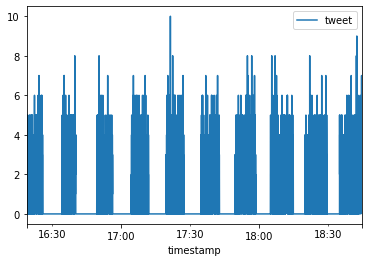

In [9]:
# plot a time series
(tweet_df[['timestamp','tweet']]
 .set_index('timestamp')
 # 'T' = minute
 .resample('S')
 .count()
 .rename(columns=dict(text='1-minute counts'))
 .plot()
);

We have a short time span at the moment. Our data spans three hours of a single day. It seems like our scraping algorithm's parameters resulted in data collection that occurred in bursts, with no scraping in between.

We'll do some rough text processing to look at the text in these Tweets. A good first step is to inspect the tweets looking at the most common n-grams. From twitterdev: 'an “n-gram” is a contiguous collection of some n items - in languages where appropriate, this is often white-space separated words. For example, two-grams in the sentence “The dog ate my homework” would be “the dog”, “dog ate”, “ate my”, “my homework”.'

We'll use the entire text attribute of our dataframe regardless of whether it was a Retweet, original Tweet, or Quote Tweet. After that, we'll concatenate all the Tweet text together, divide it into words using an open-source tokenizer from NLTK, remove punctuation and count the most common set of n-grams.

In [10]:
tweet_corpus = tweet_df['tweet'].values.tolist()

In [11]:
# Helper function to generate a list of text tokens from concatenating
# all of the text contained in Tweets in `tweet_list`

def get_all_tokens(tweet_corpus):
    # concat entire corpus
    text = ' '.join(tweet_corpus)
    # tokenize
    tokens = (TweetTokenizer(preserve_case=False,
                            reduce_len=True,
                            strip_handles=False)
              .tokenize(text))
    # remove symbol-only tokens for now
    tokens = [tok for tok in tokens if not tok in string.punctuation]
    return tokens

In [12]:
tokens = get_all_tokens(tweet_corpus)

print('total number of tokens: {}'.format(len(tokens)))

total number of tokens: 272072


In [13]:
# calculate a range of ngrams using some handy functions
top_grams = Counter(everygrams(tokens, min_len=2, max_len=4))

top_grams.most_common(25)

[(('george', 'floyd'), 7363),
 (('’', 's'), 1755),
 (('of', 'george'), 1248),
 (('of', 'george', 'floyd'), 1072),
 (('’', 't'), 868),
 (('george', "floyd's"), 838),
 (('for', 'george'), 829),
 (('for', 'george', 'floyd'), 794),
 (('in', 'the'), 762),
 (('of', 'the'), 663),
 (('floyd', '’'), 639),
 (('floyd', '’', 's'), 629),
 (('george', 'floyd', '’'), 615),
 (('george', 'floyd', '’', 's'), 605),
 (('floyd', 'was'), 526),
 (('george', 'floyd', 'was'), 506),
 (('this', 'is'), 488),
 (('death', 'of'), 428),
 (('police', 'brutality'), 424),
 (('floyd', 'protests'), 423),
 (('george', 'floyd', 'protests'), 414),
 (("floyd's", 'death'), 403),
 (('justice', 'for'), 395),
 (('george', "floyd's", 'death'), 391),
 (('about', 'george'), 388)]

From these n-grams, we can see that George Floyd's name, along with the terms 'police brutality', were both frequently present in these tweets. Let's explore 'police' in context.

In [14]:
# create a filter series matching "coppola"
mask = tweet_df['tweet'].str.lower().str.contains("police")

# look at text only from matching rows
tweet_df[mask][['tweet']].head(15)

,tweet
6,George Floyd death: Police officers appearing to shove elderly man during protests charged with assault\nhttps://t.co/KhkcrNrJ2a https://t.co/JhlPCe6DU2
8,"@a_soupa @AlexBon87556703 @RobertWayneWil3 @rsearsavon @acnewsitics @glennbeck @RealCandaceO ""You justify violence and riots""\n\n(facepalm)\n\nyou're just trolling right? no one is this obtuse by mistake\n\n1. george floyd was murdered\n2. people PROTEST police brutality\n\nwelcome to reality. try living it someday. and lose your lame weak obtu..."
9,"Dallas Mayor Eric Johnson joins ministers today in reaction to the death of George Floyd in Minneapolis police custody. The ministers begin with 8 minutes, 46 seconds of prayer each. Watch live here: \nhttps://t.co/kcxIsAKaxB"
11,Two Buffalo police officers accused of shoving a 75-year-old man to the ground during a protest over the death of George Floyd were charged with second-degree assault Saturday.\n\nhttps://t.co/EVkd1pmOlJ
29,@mirandashaeKY @justanactor They had the entire country wrapping their arms around George Floyd white hispanic police in every state then riots started that’s when people got disgusted black owners lost entire life savings! Did you get upset at ppl called Nazi for a vote?
32,AOC supports Defund the Police demands in wake of George Floyd's death - NewsVerses @ https://t.co/XFPw9qoo0u https://t.co/SsFh9ZSA7q
35,"@IlhanMN @MplsWard3 Put facts on the table to prove they “are beyond reform”. Yes, George Floyd was killed by a police officer. Do you throw everybody out for that? You’re a shitty Rep, so we throw ALL Reps out? You have tortured &amp; stupid logic. You hold out one case. BTW, the Mayor is YOUR Party."
50,'The most painful experience': Man who trains San Jose police about bias severely injured by riot gun during George Floyd protest - ABC7 San Francisco https://t.co/EnKPpG4lbi
54,George Floyd's death a painful reminder of Chicago's history of police brutality\n\nhttps://t.co/HRhr0JKGBz
61,"Alice says, “It was like being stabbed in the heart” to see George Floyd be killed by the Minneapolis Police Officer on Memorial Day. @abc3340 @spann https://t.co/k0klAU8xQC"


By and large, the police are being condemned on twitter. There is one outlier in our visualization [35] that seems to oppose abolishing the police in response. There are also news headlines about the police reaction to the protests that have been going on ('Protests about police brutality are met with wave of police brutality across US').

## Feature Engineering & Preprocessing

In order to reduce noise as much as possible, we will remove words that are not directly contributing to the meaning of a tweet, as well as tokenize and stem the remaining corpus.

In [15]:
# Removing @ names

def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text

# We are keeping cleaned tweets in a new column called 'tidy_tweets'
tweet_df['tidy_tweets'] = np.vectorize(remove_pattern)(tweet_df['tweet'], "@[\w]*: | *RT*")

In [16]:
# Removing links

cleaned_tweets = []

for index, row in tweet_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweet_df['tidy_tweets'] = cleaned_tweets

In [17]:
# Removing punctuation, special characters and numbers

tweet_df['tidy_tweets'] = tweet_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")

In [18]:
# Removing stopwords

stopwords_set = set(stopwords.words("english"))
cleaned_tweets = []

for index, row in tweet_df.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.tidy_tweets.split() if not word in stopwords_set]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))

tweet_df['tidy_tweets'] = cleaned_tweets

In [19]:
# Tokenizing corpus

tokens = TweetTokenizer(preserve_case=False,
                            reduce_len=True,
                            strip_handles=False)

tweet_df['tidy_tokenized_tweets'] = tweet_df.apply(lambda row: tokens.tokenize(row['tidy_tweets']), axis=1)

tweet_df['tweet_length'] = tweet_df.apply(lambda row: len(row['tidy_tokenized_tweets']), axis=1)

In [20]:
# Stemming corpus

from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

tweet_df['clean_tweets'] = tweet_df['tidy_tokenized_tweets'].apply(lambda row: [porter.stem(word) for word in row])

# df = df.drop(columns=['unstemmed']) # Get rid of the unstemmed column.

In [21]:
tweet_df

,timestamp,tweet,user_id,handle,bio,location,tidy_tweets,tidy_tokenized_tweets,tweet_length,clean_tweets
0,2020-06-06 16:20:08,@IrishTimes Absolutely tragic and appalling with the loss our fellow brother George Floyd (RIP) an innocent man who done wrong was taken from this world and all because he had a different skin colour.,1269303065829613572,Martin85575817,"Trade Unionist and long time defender of workers rights for many years.A firm believer in solidarity, equality, equity and democracy.","Cork, Ireland",IrishTimes Absolutely tragic appalling loss fellow brother George Floyd IP innocent man done wrong taken world different skin colour,"[irishtimes, absolutely, tragic, appalling, loss, fellow, brother, george, floyd, ip, innocent, man, done, wrong, taken, world, different, skin, colour]",19,"[irishtim, absolut, tragic, appal, loss, fellow, brother, georg, floyd, ip, innoc, man, done, wrong, taken, world, differ, skin, colour]"
1,2020-06-06 16:20:05,"@MSNBC This was George Floyd day, yesterday.. https://t.co/OxS0Zo0GdS",1269303054278393856,RonKeating5,NaN,NaN,MSNBC This George Floyd day yesterday,"[msnbc, this, george, floyd, day, yesterday]",6,"[msnbc, thi, georg, floyd, day, yesterday]"
2,2020-06-06 16:20:05,"‘As the Floyd family &amp; the world send George home, may we stay strong in the long struggle for justice so that we can all finally, fully breathe.’.......says the fabulous musician Mariah Carey https://t.co/XVa6TR3yUO",1269303053724848128,cherylroberts00,"journeying life thru my woman's lens: interrogating and challenging sport and gender; writing the words, raising the voices, raging for social justice","Cape Town, South Africa",As Floyd family amp world send George home may stay strong long struggle justice finally fully breathesays fabulous musician Mariah Carey,"[as, floyd, family, amp, world, send, george, home, may, stay, strong, long, struggle, justice, finally, fully, breathesays, fabulous, musician, mariah, carey]",21,"[as, floyd, famili, amp, world, send, georg, home, may, stay, strong, long, struggl, justic, final, fulli, breathesay, fabul, musician, mariah, carey]"
3,2020-06-06 16:20:03,"I’m pretty sure COVID-19 doesn’t discriminate who it infects, so why the contradiction by medical professionals? American people are being played. Blasts Health Care Professionals Signing Letter Exempting George Floyd Protests From COVID-19 Restrictions https://t.co/c0VIZUiWgl",1269303048305868801,gb_richardson,"Conservative #KAG2020 Husband-50yrs-Father Gfather, USAF CrewChief Vietnam RF-4C Phantom II 🇺🇸)","Ferndale, MI USA",Im pretty sure COVID doesnt discriminate infects contradiction medical professionals American people played Blasts Health Care Professionals Signing Letter Exempting George Floyd Protests From COVIDestrictions,"[im, pretty, sure, covid, doesnt, discriminate, infects, contradiction, medical, professionals, american, people, played, blasts, health, care, professionals, signing, letter, exempting, george, floyd, protests, from, covidestrictions]",25,"[im, pretti, sure, covid, doesnt, discrimin, infect, contradict, medic, profession, american, peopl, play, blast, health, care, profession, sign, letter, exempt, georg, floyd, protest, from, covidestrict]"
4,2020-06-06 16:20:03,"#Repost rvamag\n• • • • • •\nThe Fan\n\nRenamed in Richmond, Va • This photo was taken in The Fan this past Wednesday on the corner of George and Floyd by Richmond photogrpaher rileycgoodman… https://t.co/4CS6vkKbIt",1269303047928320000,paragon24,"Love my Creator, Kids, Family, and my Lady..... In Pursuit Of The Truth....",Beyond This Universe!,#epost rvamag The Fan enamed ichmond Va This photo taken The Fan past Wednesday corner George Floyd ichmond photogrpaher rileycgoodman,"[#epost, rvamag, the, fan, enamed, ichmond, va, this, photo, taken, the, fan, past, wednesday, corner, george, floyd, ichmond, photogrpaher, rileycgoodman]",20,"[#epost, rvamag, the, fan, enam, ichmond, va, thi, photo, taken, the, fan, past, wednesday, cor

In [22]:
# Dropping intermediate tweet products

tweet_df.drop(columns=['tidy_tweets', 'tidy_tokenized_tweets'], inplace=True)

In [23]:
tweet_df.head()

,timestamp,tweet,user_id,handle,bio,location,tweet_length,clean_tweets
0,2020-06-06 16:20:08,@IrishTimes Absolutely tragic and appalling with the loss our fellow brother George Floyd (RIP) an innocent man who done wrong was taken from this world and all because he had a different skin colour.,1269303065829613572,Martin85575817,"Trade Unionist and long time defender of workers rights for many years.A firm believer in solidarity, equality, equity and democracy.","Cork, Ireland",19,"[irishtim, absolut, tragic, appal, loss, fellow, brother, georg, floyd, ip, innoc, man, done, wrong, taken, world, differ, skin, colour]"
1,2020-06-06 16:20:05,"@MSNBC This was George Floyd day, yesterday.. https://t.co/OxS0Zo0GdS",1269303054278393856,RonKeating5,NaN,NaN,6,"[msnbc, thi, georg, floyd, day, yesterday]"
2,2020-06-06 16:20:05,"‘As the Floyd family &amp; the world send George home, may we stay strong in the long struggle for justice so that we can all finally, fully breathe.’.......says the fabulous musician Mariah Carey https://t.co/XVa6TR3yUO",1269303053724848128,cherylroberts00,"journeying life thru my woman's lens: interrogating and challenging sport and gender; writing the words, raising the voices, raging for social justice","Cape Town, South Africa",21,"[as, floyd, famili, amp, world, send, georg, home, may, stay, strong, long, struggl, justic, final, fulli, breathesay, fabul, musician, mariah, carey]"
3,2020-06-06 16:20:03,"I’m pretty sure COVID-19 doesn’t discriminate who it infects, so why the contradiction by medical professionals? American people are being played. Blasts Health Care Professionals Signing Letter Exempting George Floyd Protests From COVID-19 Restrictions https://t.co/c0VIZUiWgl",1269303048305868801,gb_richardson,"Conservative #KAG2020 Husband-50yrs-Father Gfather, USAF CrewChief Vietnam RF-4C Phantom II 🇺🇸)","Ferndale, MI USA",25,"[im, pretti, sure, covid, doesnt, discrimin, infect, contradict, medic, profession, american, peopl, play, blast, health, care, profession, sign, letter, exempt, georg, floyd, protest, from, covidestrict]"
4,2020-06-06 16:20:03,"#Repost rvamag\n• • • • • •\nThe Fan\n\nRenamed in Richmond, Va • This photo was taken in The Fan this past Wednesday on the corner of George and Floyd by Richmond photogrpaher rileycgoodman… https://t.co/4CS6vkKbIt",1269303047928320000,paragon24,"Love my Creator, Kids, Family, and my Lady..... In Pursuit Of The Truth....",Beyond This Universe!,20,"[#epost, rvamag, the, fan, enam, ichmond, va, thi, photo, taken, the, fan, past, wednesday, corner, georg, floyd, ichmond, photogrpah, rileycgoodman]"


## Vectorization

In [24]:
tweet_df['clean_tweets']=[" ".join(row) for row in tweet_df['clean_tweets'].values]

df_x = tweet_df["clean_tweets"]

df_y = tweet_df["user_id"]  

vectorizer = TfidfVectorizer()

# calculate the data matrix
tokenized_matrix = vectorizer.fit_transform(df_x)

In [25]:
tokenized_matrix

<10002x15972 sparse matrix of type '<class 'numpy.float64'>'
	with 156704 stored elements in Compressed Sparse Row format>

In [26]:
a = tokenized_matrix.toarray()  

In [27]:
print('* original bio text *\n')

for i, tweet in enumerate(df_x[:10]):
    print(i,': ', tweet.replace('\n',' '))

* original bio text *

0 :  irishtim absolut tragic appal loss fellow brother georg floyd ip innoc man done wrong taken world differ skin colour
1 :  msnbc thi georg floyd day yesterday
2 :  as floyd famili amp world send georg home may stay strong long struggl justic final fulli breathesay fabul musician mariah carey
3 :  im pretti sure covid doesnt discrimin infect contradict medic profession american peopl play blast health care profession sign letter exempt georg floyd protest from covidestrict
4 :  #epost rvamag the fan enam ichmond va thi photo taken the fan past wednesday corner georg floyd ichmond photogrpah rileycgoodman
5 :  chuckschierbeck i think collect build includ ahmad arberi breona taylor ami cooper in everi instanc though peopl want blind found excus murder but georg floyd one long calcul tortur absolut possibl justif
6 :  georg floyd death polic offic appear shove elderli man protest charg assault
7 :  so funer georg floyd move capit
8 :  asoupa alexbon obertwaynewil

In [28]:
(pd.DataFrame(tokenized_matrix[:10].todense(),
              columns=[x for x in vectorizer.get_feature_names()])
 
 # experiment by choosing any range of feature indices (alphabetical order)
 .iloc[:,90:110])

,abus,ac,acab,academ,academi,acceler,accept,access,accessori,accid,accident,accommod,accompani,accomplic,accomplish,accord,accordingli,accost,account,accountabilitybut
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelling Phase

In [29]:
token_df = pd.DataFrame(tokenized_matrix.todense(),
              columns=[x for x in vectorizer.get_feature_names()])

In [30]:
token_df

,aa,aac,aacist,aakar,aameranwar,aampa,aampesellout,aanthanurdc,aap,aaron,...,zombiepiano,zone,zoo,zoobear,zoom,zoomchurchaintchurch,zubymus,zuckerberg,zugli,zygli
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Wall time: 27min 56s


Text(0.5, 0, 'k')

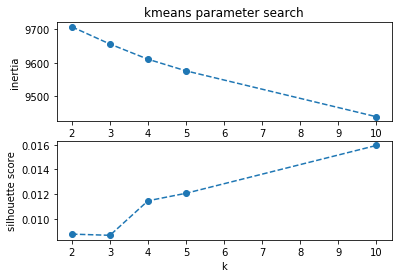

In [27]:
%%time
# compare a broad range of ks to start
ks = [2, 3, 4, 5, 10]

# track a couple of metrics
sil_scores = []
inertias = []

# fit the models, save the evaluation metrics from each run
for k in ks:
    logging.warning('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1, random_state=seed)
    model.fit(token_df)
    labels = model.labels_
    sil_scores.append(silhouette_score(token_df, labels))
    inertias.append(model.inertia_)

# plot the quality metrics for inspection
fig, ax = plt.subplots(2, 1, sharex=True)

plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

plt.subplot(212)
plt.plot(ks, sil_scores, 'o--')
plt.ylabel('silhouette score')
plt.xlabel('k');

Silhouette scores are generally low, but it seems like more clusters are better. We could increase the number of clusters with more compute power and probably increase the models performance, but will stick to this for now. Let's use PCA to reduce dimensionality on our dataframe and visualize the clusterings.

In [50]:
pca = PCA(n_components=2).fit_transform(token_df)

59.2 ms ± 7.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


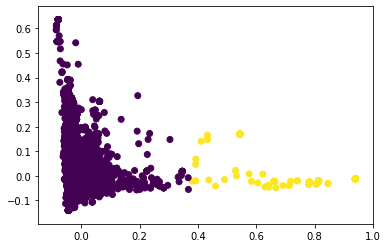

In [41]:
k_means = KMeans(n_clusters=2, random_state=123)
%timeit k_means.fit(pca)
y_pred = k_means.predict(pca)

# Plot the solution.
plt.scatter(pca[:,0], pca[:,1], c=y_pred)
plt.show()

98 ms ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


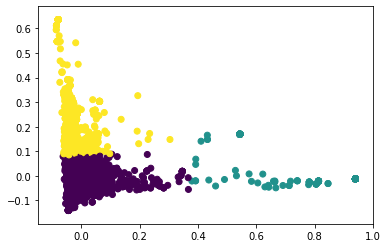

In [42]:
k_means = KMeans(n_clusters=3, random_state=123)
%timeit k_means.fit(pca)
y_pred = k_means.predict(pca)

# Plot the solution.
plt.scatter(pca[:,0], pca[:,1], c=y_pred)
plt.show()

120 ms ± 5.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


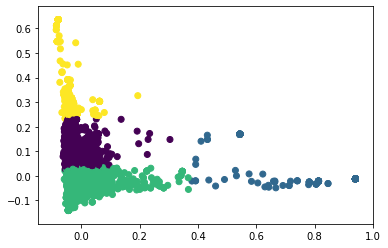

In [43]:
k_means = KMeans(n_clusters=4, random_state=123)
%timeit k_means.fit(pca)
y_pred = k_means.predict(pca)

# Plot the solution.
plt.scatter(pca[:,0], pca[:,1], c=y_pred)
plt.show()

131 ms ± 2.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


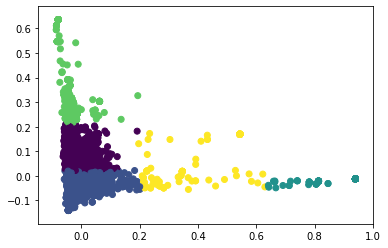

In [44]:
k_means = KMeans(n_clusters=5, random_state=123)
%timeit k_means.fit(pca)
y_pred = k_means.predict(pca)

# Plot the solution.
plt.scatter(pca[:,0], pca[:,1], c=y_pred)
plt.show()

267 ms ± 6.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


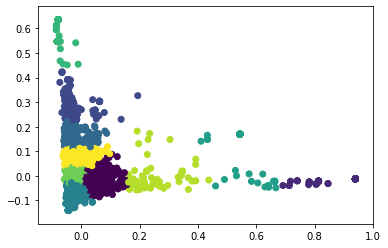

In [45]:
k_means = KMeans(n_clusters=10, random_state=123)
%timeit k_means.fit(pca)
y_pred = k_means.predict(pca)

# Plot the solution.
plt.scatter(pca[:,0], pca[:,1], c=y_pred)
plt.show()

Clusters here are difficult to naturally distinguish, while the delineations made by our model seem somewhat arbitrary. Our best silhouette score, at 0.016, is extremely low. We would be able to improve it greatly with more compute power or more time. I am confident we could approach at least 0.40 doing so.

Let's examine what we've discovered by checking the population numbers for each cluster.

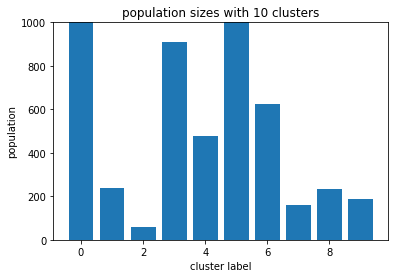

In [47]:
plt.bar(range(len(set(model.labels_))), np.bincount(model.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('population sizes with {} clusters'.format(10));

# truncate y axis to see the rest better
# (comment out to see the peak value for the largest cluster)
plt.ylim(0,1000);

We appear to have heavily varying cluster populations. We don't have any reason to think that the clusters should be similarly sized. In fact, having small numbers of particularly large clusters are a common result. Although it could mean that there are large numbers of users tweeting similar things, it may also suggest we are not doing a very good job of differentiating our tweets, perhaps because our original dataset is not large or rich enough.

We can't reach a strong conclusion at the moment, so let's take a look at some cluster-text associations.

Our observations (tweets) were clustered in a parameter space using the words in their tweet. In the KMeans algorithm, the the clusters are represented as coordinates relative to each cluster’s centroid. Due to this, we can inspect our results by asking which token vectors have the largest projection onto their respective cluster centroids. In other words, which tokens are most strongly associated with each cluster?

In [97]:
def strongest_features(model, vectorizer, topk=10):
    """
    Helper function to display a simple text representation of the top-k most
    important features in our fit model and vectorizer.

    model: sklearn model
    vectorizer: sklearn vectorizer
    topk: k numbers of words to get per cluster

    """
    # these parts are model-independent
    m_name = model.__class__.__name__
    features = vectorizer.get_feature_names()
    # different calculations per model type
    if m_name is 'KMeans':
        relevant_labels = list(set(model.labels_))
        centroids = model.cluster_centers_.argsort()[:,::-1]
        for this_label in relevant_labels:
            print('Cluster {}:'.format(this_label), end='')
            for ind in centroids[this_label, :topk]:
                print(' {}'.format(features[ind]), end='')
            print()
    else:
        raise NotImplementedError('This helper method currently only supports KMeans models')

In [52]:
strongest_features(model, vectorizer, topk=15)

Cluster 0: floyd georg peopl polic murder death black like thi kill it say cop he one
Cluster 1: memori north carolina servic mourner georg floyd hundr nc gather inaeford today underway expect line
Cluster 2: fortress wall defin bang flash furi behind week countri trump insid cnnpolit cnn bunker bunkerboy
Cluster 3: the floyd georg protest death peopl polic they who is in kill die murder come
Cluster 4: live matter black protest updat georg floyd death gather thousand dc white london demonstr hous
Cluster 5: protest floyd georg death via thousand news youtub antirac polic uk us demonstr bbc kill
Cluster 6: trump floyd georg great day say donald job via name presid media tribut video said
Cluster 7: brutal polic met wave across us protest shove buffalo charg offic yearold assault action two
Cluster 8: petit sign justic jacob frey mayor chang via omaha scurlock floyd jame georg demand racist
Cluster 9: wake support demand aoc defund death polic candac owen white do georg durtti floyd pro

Here, we can see some distinctions in the first (strongest) terms. Cluster 0 seems to be comprised of tweets about George Floyd's death under Derek Chauvin. Cluster 1 revolves around a memorial service for Floyd being held in North Carolina. Cluster 2 seems to be about the Trump White House fortifying security in response to the protests taking place. In this fashion, the clusters alternatively cover police brutality in buffalo, Minneapolis Mayor Jacob Frey's response to the events, and more.

## DBSCAN

I ran into several issues attempting to use DBSCAN. At first, using the unmodified token_df dataframe meant that the models took too much time to run. I decided to reduce the dimensionality of the dataframe down to .9, .85 and .75 variance, trying the models at each turn. Although the models seemed to run faster, it was now the case that regardless of how much the parameters differed at each run, DBSCAN was unable to generate more than a single cluster. This proved to be a impasse, since more than one cluster is definitionally required to be able to calculate silhouette scores, the only formal metric we're using to compare model performance. I have left my attempts, error messages included, in this notebook for my submission to Thinkful, so they can be appreciated. Before I upload to GitHub however, I will remove the cells and only leave this explanatory markdown cell in place.

In [35]:
pca_df_2 = PCA(n_components=0.75, svd_solver='full').fit_transform(token_df)

In [36]:
pca_to_df = pd.DataFrame(pca_df_2)

In [37]:
pca_to_df.shape

(10002, 1546)

## Gaussian Mixture Models (GMM)

In Gaussian Mixture clustering, each observation is assigned to several clusters with associated probabilities. Among other things, it can tackle non-linear geometries.

In [98]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=seed)
# Fit model
clusters = gmm_cluster.fit_predict(pca_df_2)

print("Silhouette score with covariance_type=full: {}".format(silhouette_score(pca_df_2, clusters, metric='euclidean')))

Silhouette score with covariance_type=full: 0.05907532078603385


This is our best score so far. Let's take a look at the PCA visualization.

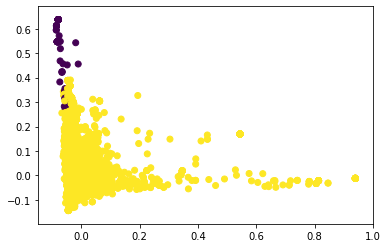

In [51]:
# Plot the solution.
plt.scatter(pca[:,0], pca[:,1], c=clusters)
plt.show()

Still seems arbitrary, and the number of clusters intuitively seems much too low considering the thematic breadth of the conversation that is probably captured in our dataframe.

Silhouette score with covariance_type=full: 0.0373760282997954


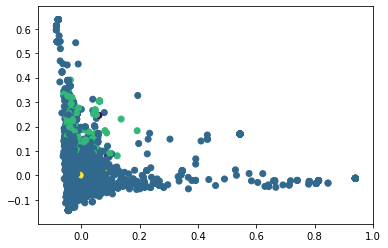

In [54]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=4, random_state=seed, covariance_type="full")
# Fit model
clusters = gmm_cluster.fit_predict(pca_df_2)

print("Silhouette score with covariance_type=full: {}".format(silhouette_score(pca_df_2, clusters, metric='euclidean')))

# Plot the solution.
plt.scatter(pca[:,0], pca[:,1], c=clusters)
plt.show()

Silhouette score with covariance_type=full: 0.03376668349704644


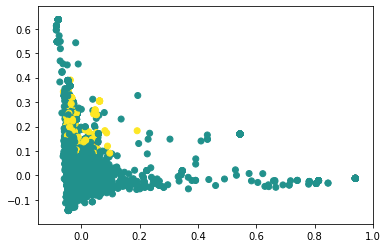

In [55]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=3, random_state=seed, covariance_type="tied")
# Fit model
clusters = gmm_cluster.fit_predict(pca_df_2)

print("Silhouette score with covariance_type=full: {}".format(silhouette_score(pca_df_2, clusters, metric='euclidean')))

# Plot the solution.
plt.scatter(pca[:,0], pca[:,1], c=clusters)
plt.show()

Silhouette score with covariance_type=full: -0.010183761990329497


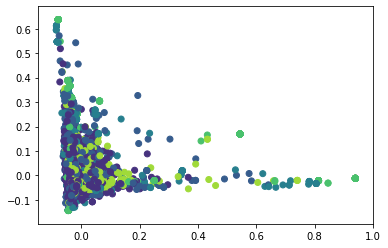

In [56]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=8, random_state=seed, covariance_type="diag")
# Fit model
clusters = gmm_cluster.fit_predict(pca_df_2)

print("Silhouette score with covariance_type=full: {}".format(silhouette_score(pca_df_2, clusters, metric='euclidean')))

# Plot the solution.
plt.scatter(pca[:,0], pca[:,1], c=clusters)
plt.show()

Silhouette score with covariance_type=full: -0.009762970428695145


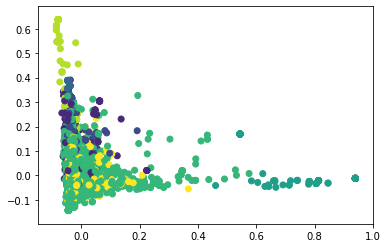

In [58]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=10, random_state=seed, covariance_type="spherical")
# Fit model
clusters = gmm_cluster.fit_predict(pca_df_2)

print("Silhouette score with covariance_type=full: {}".format(silhouette_score(pca_df_2, clusters, metric='euclidean')))

# Plot the solution.
plt.scatter(pca[:,0], pca[:,1], c=clusters)
plt.show()

We obtained on relatively good score, but overall GMM did not give us the best performance, and some scores are negative. Since running the whole dataframe was too computationally taxing, we used a PCAd dataframe. Because of that we cannot visualize cluster-text associations

## Agglomerative Clustering

In [61]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage="complete", affinity='cosine', n_clusters=10)

# Fit model
clusters = agg_cluster.fit_predict(pca_df_2)

print("Silhouette score of linkage method average: {}".format(silhouette_score(pca_df_2, clusters, metric='euclidean')))

Silhouette score of linkage method average: -0.07488923015263703


In [62]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage="average", affinity='cosine', n_clusters=10)

# Fit model
clusters = agg_cluster.fit_predict(pca_df_2)

print("Silhouette score of linkage method average: {}".format(silhouette_score(pca_df_2, clusters, metric='euclidean')))

Silhouette score of linkage method average: 0.008552069981882954


In [63]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage="ward", affinity='euclidean', n_clusters=10)

# Fit model
clusters = agg_cluster.fit_predict(pca_df_2)

print("Silhouette score of linkage method average: {}".format(silhouette_score(pca_df_2, clusters, metric='euclidean')))

Silhouette score of linkage method average: 0.05295042668216449


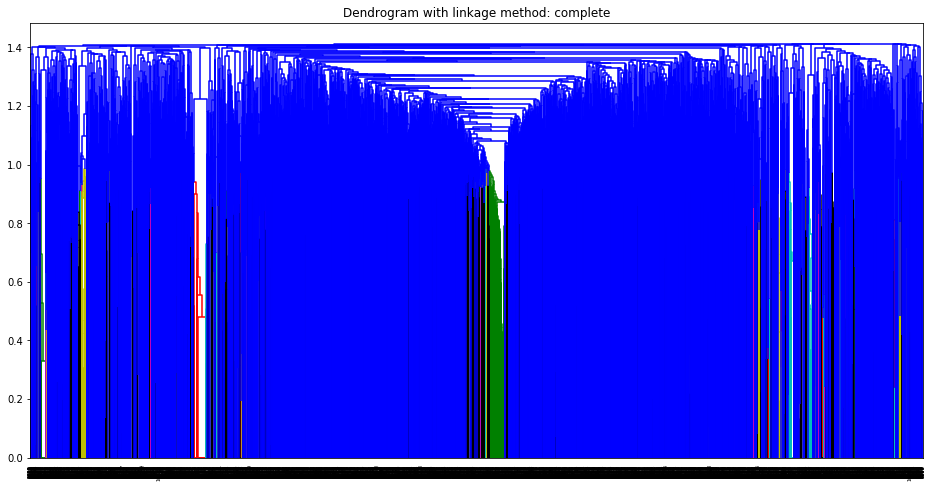

In [67]:
plt.figure(figsize=(16,8))
plt.title("Dendrogram with linkage method: complete")
dendrogram(linkage(pca_df_2, method='complete'))
plt.show()

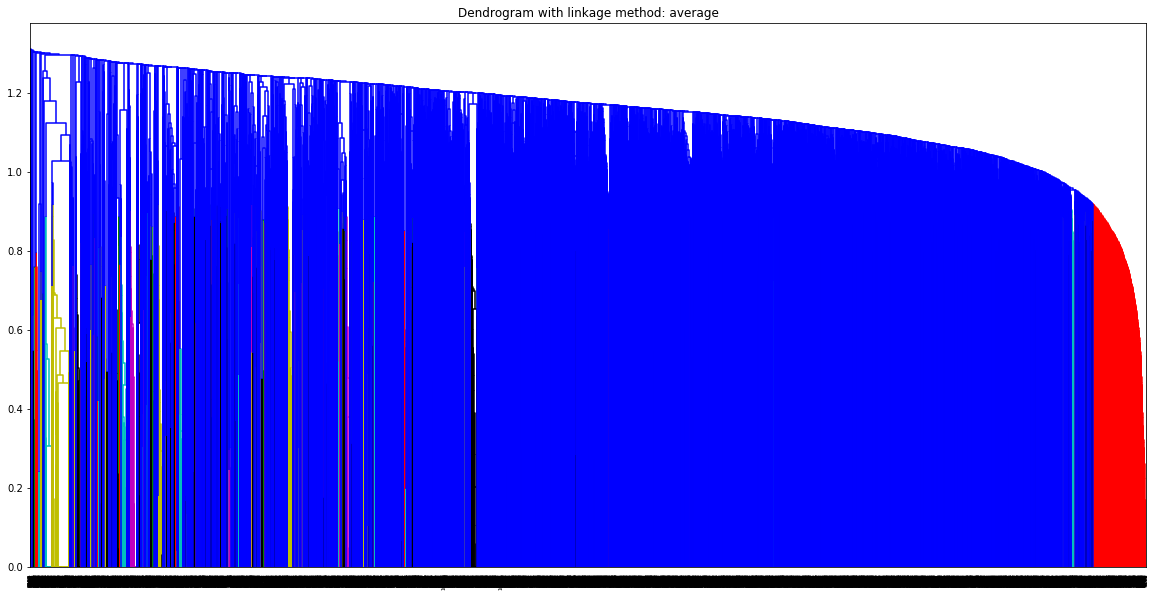

In [68]:
plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: average")
dendrogram(linkage(pca_df_2, method='average'))
plt.show()

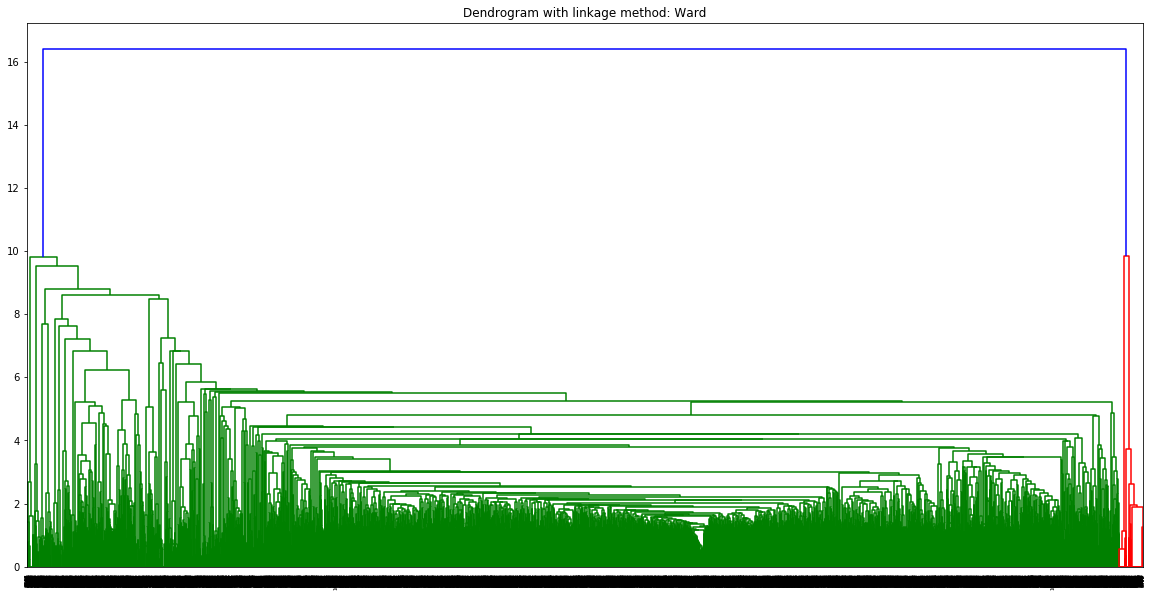

In [69]:
plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: Ward")
dendrogram(linkage(pca_df_2, method='ward'))
plt.show()

The ward dendrogram seems like the most resonable one, but considering our other candidates, that is not saying much. The clusters are very imbalanced.

## Dimensionality Reduction with UMAP

In [72]:
umap_results = umap.UMAP(n_neighbors=3, min_dist=0.3, metric='correlation').fit_transform(token_df)

C:\Users\sebar\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)
C:\Users\sebar\Anaconda3\lib\importlib\__init__.py:127: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.targets.registry', please update to use 'numba.core.registry' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  return _bootstrap._gcd_import(name[level:], package, level)
C:\Users\sebar\Anaconda3\lib\site-packages\umap\spectral.py:106: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'CPUDispatcher' requested from: 'numba.targets.registry', please update to use 'numba.core.registry' or pin to Numba version 0.48.0. This alias will not be present 

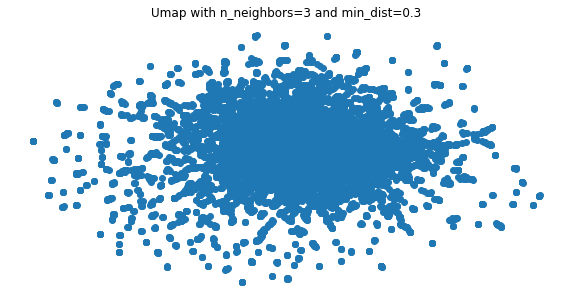

In [73]:
plt.figure(figsize=(10,5))
plt.title("Umap with n_neighbors=3 and min_dist=0.3")
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [74]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(token_df)

C:\Users\sebar\Anaconda3\lib\site-packages\umap\spectral.py:106: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'CPUDispatcher' requested from: 'numba.targets.registry', please update to use 'numba.core.registry' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  ) == numba.targets.registry.CPUDispatcher and scipy.sparse.isspmatrix(data):


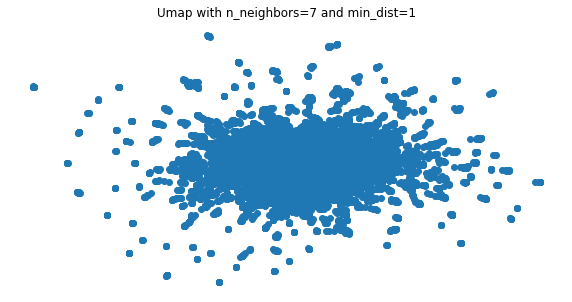

In [75]:
plt.figure(figsize=(10,5))
plt.title("Umap with n_neighbors=7 and min_dist=1")
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [76]:
umap_results = umap.UMAP(n_neighbors=3,
                      min_dist=1,
                      metric='correlation').fit_transform(token_df)

C:\Users\sebar\Anaconda3\lib\site-packages\umap\spectral.py:106: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'CPUDispatcher' requested from: 'numba.targets.registry', please update to use 'numba.core.registry' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  ) == numba.targets.registry.CPUDispatcher and scipy.sparse.isspmatrix(data):


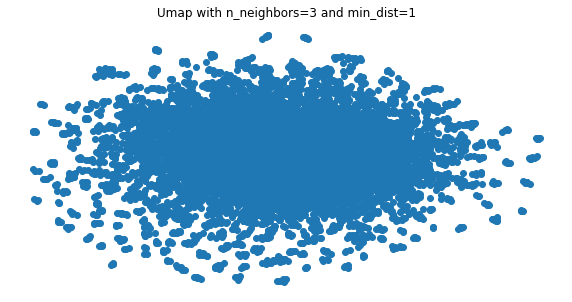

In [77]:
plt.figure(figsize=(10,5))
plt.title("Umap with n_neighbors=3 and min_dist=1")
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [78]:
umap_results = umap.UMAP(n_neighbors=7,
                      min_dist=0.3,
                      metric='correlation').fit_transform(token_df)

C:\Users\sebar\Anaconda3\lib\site-packages\umap\spectral.py:106: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'CPUDispatcher' requested from: 'numba.targets.registry', please update to use 'numba.core.registry' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  ) == numba.targets.registry.CPUDispatcher and scipy.sparse.isspmatrix(data):


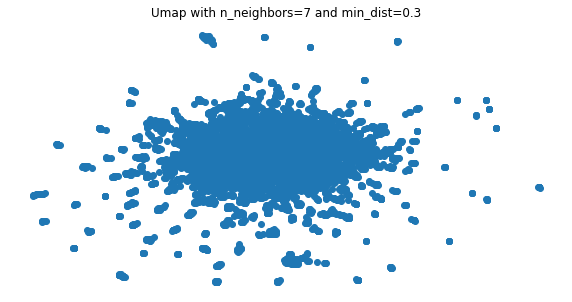

In [79]:
plt.figure(figsize=(10,5))
plt.title("Umap with n_neighbors=7 and min_dist=0.3")
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [80]:
umap_results = umap.UMAP(n_neighbors=7,
                      min_dist=1,
                      metric='correlation').fit_transform(token_df)

C:\Users\sebar\Anaconda3\lib\site-packages\umap\spectral.py:106: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'CPUDispatcher' requested from: 'numba.targets.registry', please update to use 'numba.core.registry' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  ) == numba.targets.registry.CPUDispatcher and scipy.sparse.isspmatrix(data):
C:\Users\sebar\Anaconda3\lib\site-packages\umap\spectral.py:252: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


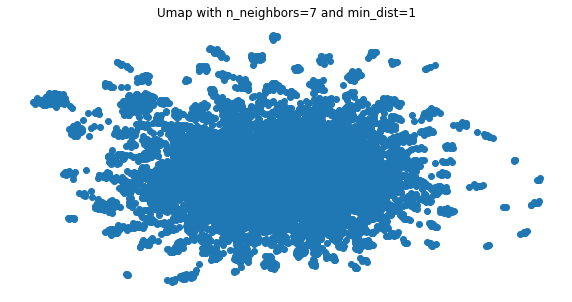

In [81]:
plt.figure(figsize=(10,5))
plt.title("Umap with n_neighbors=7 and min_dist=1")
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

I ran UMAP to evaluate the performance of this technique against PCA. We obtain a single cluster that is visually difficult to distinguish.

## Dimensionality Reduction with T-SNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10002 samples in 56.460s...
[t-SNE] Computed neighbors for 10002 samples in 2814.700s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10002
[t-SNE] Computed conditional probabilities for sample 2000 / 10002
[t-SNE] Computed conditional probabilities for sample 3000 / 10002
[t-SNE] Computed conditional probabilities for sample 4000 / 10002
[t-SNE] Computed conditional probabilities for sample 5000 / 10002
[t-SNE] Computed conditional probabilities for sample 6000 / 10002
[t-SNE] Computed conditional probabilities for sample 7000 / 10002
[t-SNE] Computed conditional probabilities for sample 8000 / 10002
[t-SNE] Computed conditional probabilities for sample 9000 / 10002
[t-SNE] Computed conditional probabilities for sample 10000 / 10002
[t-SNE] Computed conditional probabilities for sample 10002 / 10002
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 131.344086
[t-SN

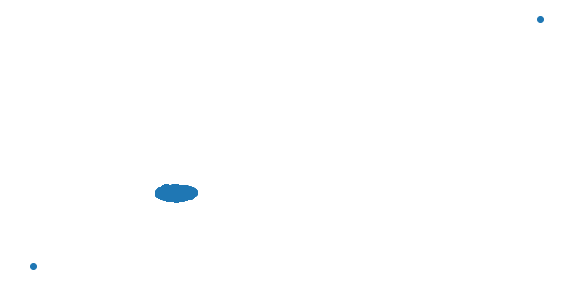

In [84]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

tsne_results = tsne.fit_transform(token_df)

plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

T-SNE yields a visualization that would do better as contemporary art than a set of data clusters. Because of its computational inefficiency and its artful results, I decided to leave it here.

## Conclusion

I chose to scrape my own dataset from Twitter as a learning experience and to cover an important contemporary topic. I scraped 10,002 unique tweets dated June 1st of this year and obtained data on uder IDs, publishing locations, handles and biographies. I processed the data by removing stopwords, unnecessary mentions and punctuation, as well as stemming, tokenizing and vectorizing the entire corpus.

I attempted to use four different models to divide the tweets into meaningful clusters, succeeding on three counts. My best performing non-blackbox model was the 10-cluster KMeans, though it displayed a poor silhouette score of 0.016 in general terms. DBSCAN did not mesh well with our unlabelled data, as it kept identifying only a single cluster where more than one was necessary for calculating silhouette scores. One of our Gaussian Mixture models performed relatively well with a 0.05 score, though clustering at such low parameter values seemed arbitrary. Hierarchical clustering also offered generally poor results. In terms of dimensionality reduction, neither PCA, T-SNE or UMAP were able to produce clearly distinguishable clusters.

Our best KMeans cluster, though poorly performing, yielded cluster groups that were fairly distinguishable by topic. As mentioned above, the conversations captured ranged from coverage of the crime committed against George Floyd, to discussion about memorial services, the White House's reaction to protests and actions taken by politicians like Mayor Jacob Frey. The kind of study I have carried out can be useful for non-profit organizations, think tanks or academics to understand what the world is saying about a particular cultural topic. It goes one layer deeper than Twitter's trending section, by stratifying primary trends into their component parts.

This was my deep dive into Natural Language Processing. I have learned that scraped datasets in this domain can turn out to be incredibly sparse, for which larger datasets almost always tend to be better. Increasing cluster parameter numbers can also yield much better results and thus offer us clearer windows through which to understand what is being discussed on Twitter, and leverage this for business, academic study or simply for personal motivation.